In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import interpolate

In [13]:
import Physical_Const as phys
h=phys.h 
c=phys.c
G=phys.G
Msun=phys.Msun
mn=phys.mn # Neutron mass


Sigma=mn**4.0*c**3.0/(8.0*np.pi**2*(h/(2.0*np.pi))**3.0) #Dimensions of energy density
b=c/np.sqrt(Sigma*G) # Dimensions of radius
mdim=b*c**2.0/G # Dimensions of mass
pdim=Sigma*c**2 # Dimensions of pressure

In [14]:
rhoNL3,PNL3=np.loadtxt('EOSFull_NL3_BPS02.dat',usecols=(0,1),unpack=True)
P_NL3=interpolate.interp1d(rhoNL3/Sigma,PNL3/pdim)
rho_NL3=interpolate.interp1d(PNL3/pdim,rhoNL3/Sigma)

rhoSLy,PSLy=np.loadtxt('EOS/sly.dat',usecols=(2,1),unpack=True)
P_SLy=interpolate.interp1d(rhoSLy/Sigma,(PSLy*c**2)/pdim)
rho_SLy=interpolate.interp1d((PSLy*c**2)/pdim,rhoSLy/Sigma)

rhoBSK19,PBSK19=np.loadtxt('EOS/bsk19.dat',usecols=(2,1),unpack=True)
P_BSK19=interpolate.interp1d(rhoBSK19/Sigma,(PBSK19*c**2)/pdim)
rho_BSK19=interpolate.interp1d((PBSK19*c**2)/pdim,rhoBSK19/Sigma)

rhoBSK20,PBSK20=np.loadtxt('EOS/bsk20.dat',usecols=(2,1),unpack=True)
P_BSK20=interpolate.interp1d(rhoBSK20/Sigma,(PBSK20*c**2)/pdim)
rho_BSK20=interpolate.interp1d((PBSK20*c**2)/pdim,rhoBSK20/Sigma)

rhoALF1,PALF1=np.loadtxt('EOS/alf1.dat',usecols=(2,1),unpack=True)
P_ALF1=interpolate.interp1d(rhoALF1/Sigma,(PALF1*c**2)/pdim)
rho_ALF1=interpolate.interp1d((PALF1*c**2)/pdim,rhoALF1/Sigma)

rhoH1,PH1=np.loadtxt('EOS/H1.dat',usecols=(2,1),unpack=True)
P_H1=interpolate.interp1d(rhoH1/Sigma,(PH1*c**2)/pdim)
rho_H1=interpolate.interp1d((PH1*c**2)/pdim,rhoH1/Sigma)



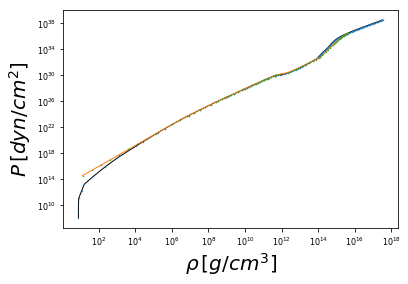

In [15]:
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

fig=plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.loglog(rhoNL3,P_NL3(rhoNL3/Sigma)*pdim,'k-', \
           linewidth=1,label="Interpolation") # Interpolación
plt.loglog(rhoNL3,PNL3,'o', \
           markersize=0.5,label='Data') # Valores de la tabla

plt.loglog(rhoSLy,P_SLy(rhoSLy/Sigma)*pdim,'-', \
           linewidth=1,label="Interpolation") # Interpolación
plt.loglog(rhoSLy,PSLy*c**2,'o', \
           markersize=0.5,label='Data') # Valores de la tabla

#plt.loglog(rhoBSK19,P_BSK19(rhoBSK19/Sigma)*pdim,'-', \
 #          linewidth=1.2,label="Interpolation") # Interpolación
#plt.loglog(rhoBSK19,PBSK19*c**2,'o', \
 #          markersize=.3,label='Data') # Valores de la tabla

#plt.loglog(rhoBSK20,P_BSK20(rhoBSK20/Sigma)*pdim,'-', \
 #          linewidth=1.2,label="Interpolation") # Interpolación
#plt.loglog(rhoBSK20,PBSK20*c**2,'o', \
 #          markersize=3,label='Data') # Valores de la tabla

#plt.loglog(rhoALF1,P_ALF1(rhoALF1/Sigma)*pdim,'-', \
 #          linewidth=1.2,label="Interpolation") # Interpolación
#plt.loglog(rhoALF1,PALF1*c**2,'o', \
 #          markersize=3,label='Data') # Valores de la tabla

#plt.loglog(rhoH1,P_H1(rhoH1/Sigma)*pdim,'-', \
 #          linewidth=1.2,label="Interpolation") # Interpolación
#plt.loglog(rhoH1,PH1*c**2,'o', \
 #          markersize=3,label='Data') # Valores de la tabla
    
    
plt.xlabel(r'$\rho\,[g/cm^3]$')
plt.ylabel(r'$P\,[dyn/cm^{2}]$')
plt.savefig('EOSs1.png', format='png', dpi=1000)
#plt.savefig('NL3EoS.eps')
plt.show()
plt.clf()

In [29]:
def StaticSeqMR(y0,r0,dr,rhoEoS):
    def TOV(r,y):
        mns, pns, nuns = y
        #print(pns*pdim)
        dmdr=4.0*np.pi*r**2.0*rhoEoS(pns)
        dnudr=(4.0*np.pi*r**3.0*pns+mns)/(r*(r-2.0*mns))
        dpdr=-dnudr*(pns+rhoEoS(pns))
        return [dmdr,dpdr,dnudr]

    Static=integrate.ode(TOV).set_integrator('dopri5',atol=1e-9) # Dopri (Dorman-Prince method) is a R-K method of order (4)5
    Static.set_initial_value(y0,r0)
    while Static.successful() and rhoEoS(Static.y[1])*Sigma>1e+6 and Static.y[1]>0:
        Static.integrate(Static.t+dr)
    mstar=Static.y[0]
    rstar=Static.t
    nustar=np.log(1-2.0*Static.y[0]/Static.t)-Static.y[2]  
    return [mstar*mdim/Msun,rstar*b*1e-5,rhoEoS(y0[1])*Sigma] 
    # Returns mass of the star in solar masses, radius of the star in km and rho_c in cgs

In [30]:
def MRrho(m0,nu0,r0,dr,rhosc,rhoEoS,PEoS):
    psc=PEoS(rhosc/Sigma) #Range of central central pressures
    MM=[];RR=[];rhorho=[]

    for pc in psc:
        MRrho=StaticSeqMR([m0,pc,nu0],r0,dr,rhoEoS)
       # print(MRrho)
        RR=RR+[MRrho[1]]
        MM=MM+[MRrho[0]]
        rhorho=rhorho+[MRrho[2]]
        
    return [RR,MM,rhorho]

In [33]:
#Range of central densities
n=np.arange(14.1,16,0.05)
rhosc=10.0**n 

#Initial values
dr=1e-4 # Step size
r0=dr/1000.0 # Initial point
m0=0 
nu0=0

ValueError: A value in x_new is below the interpolation range.

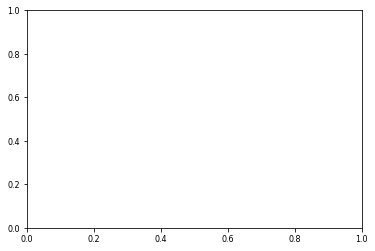

In [34]:
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

fig=plt.figure()
ax = fig.add_subplot(1, 1, 1)

MRSLy=MRrho(m0,nu0,r0,dr,rhosc,rho_ALF1,P_ALF1)

plt.plot(MRSLy[0], MRSLy[1],'b-', linewidth=1.2) 
plt.xlabel(r'$R\,[km]$')
plt.ylabel(r'$M/M_{\odot}$')
plt.savefig('MRrel.png', format='png', dpi=1000)
#plt.savefig('MRrel_NL3.eps')
plt.show()
plt.clf()